Normalization check for the initial condition: $|\Psi(x,0)|**2=0.9999999999999999$


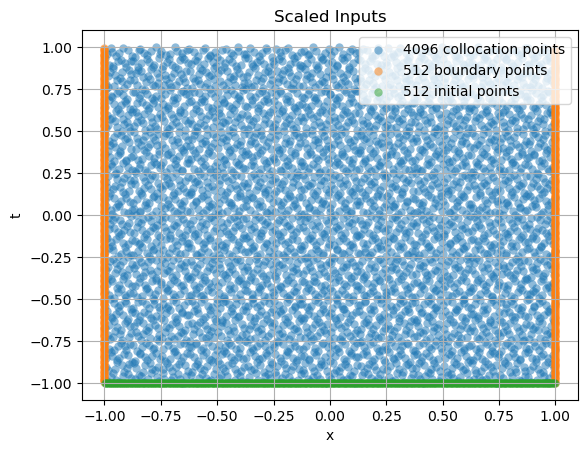

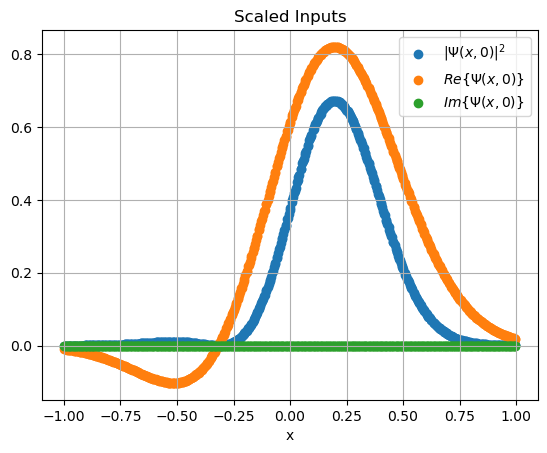

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.qmc import Sobol

import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def generate_sobol_points(n_points, x_bounds, t_bounds):
    sampler = Sobol(d=2, scramble=True)
    sobol_sample = sampler.random(n=n_points)

    x_min, x_max = float(x_bounds[0]), float(x_bounds[1])
    t_min, t_max = float(t_bounds[0]), float(t_bounds[1])

    x_sobol = x_min + (x_max - x_min) * sobol_sample[:, 0]
    t_sobol = t_min + (t_max - t_min) * sobol_sample[:, 1]

    return tf.convert_to_tensor(x_sobol, dtype=DTYPE), tf.convert_to_tensor(t_sobol, dtype=DTYPE)

def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2) * x * tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 4096, 256, 512
# N_f, N_b, N_i = 5, 5, 5

# interior points
x_f, t_f = generate_sobol_points(N_f, (x_min, x_max), (t_min, t_max))
# scaled interior points
x_f = scale_inputs(x_f, x_min, x_max)
t_f = scale_inputs(t_f, t_min, t_max)
x_f = tf.expand_dims(x_f, axis=1)
t_f = tf.expand_dims(t_f, axis=1)

# boundary points
x_lb, t_lb = generate_sobol_points(N_b, (x_min, x_min), (t_min, t_max))
x_rb, t_rb = generate_sobol_points(N_b, (x_max, x_max), (t_min, t_max))
# scaled boundary points
x_lb = scale_inputs(x_lb, x_min, x_max)
t_lb = scale_inputs(t_lb, t_min, t_max)
x_rb = scale_inputs(x_rb, x_min, x_max)
t_rb = scale_inputs(t_rb, t_min, t_max)

x_b = tf.concat([x_lb, x_rb], axis=0)
t_b = tf.concat([t_lb, t_rb], axis=0)
x_b = tf.expand_dims(x_b, axis=1)
t_b = tf.expand_dims(t_b, axis=1)

# initial points
x_i, t_i = generate_sobol_points(N_i, (x_min, x_max), (t_min, t_min))
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)
# scaled initial points
x_i = scale_inputs(x_i, x_min, x_max)
t_i = scale_inputs(t_i, t_min, t_max)
x_i = tf.expand_dims(x_i, axis=1)
t_i = tf.expand_dims(t_i, axis=1)

# normalized psi_i (Riemann sum approximation)
dx_i = (x_max - x_min) / N_i
norm = tf.math.sqrt(tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i)
psi_i_Re = tf.math.real(psi_i) / norm
psi_i_Im = tf.math.imag(psi_i) / norm

# verify normalization
norm_check = tf.reduce_sum(psi_i_Re**2 + psi_i_Im**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# grid for normalization penalty
N_grid = 200
x_grid = tf.linspace(x_min, x_max, N_grid)[:, None]  # shape (N_grid, 1)
x_grid = scale_inputs(x_grid, x_min, x_max)

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b*2} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# plotting initial condition
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'$|\Psi(x,0)|^2$')
plt.scatter(x_i, psi_i_Re, label=r'$Re\{\Psi(x,0)\}$')
plt.scatter(x_i, psi_i_Im, label=r'$Im\{\Psi(x,0)\}$')
plt.xlabel('x')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [2]:
# define Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, omega):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t], axis=1)
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x)
        v_x = tape1.gradient(v, x)
        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    del tape1, tape2

    potential = 0.5 * omega**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def loss_fn(model, interior, boundary, initial, w, x_grid):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    omega = w

    f_u, f_v = pde_residual(model, x_f, t_f, omega)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v))

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2]))

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i)))
    
    # normalization penalty
    N_t = 15
    t_rand = tf.random.uniform((N_t, 1), t_min, t_max, dtype=DTYPE)
    norm_penalty_total = 0.0

    for t_val in tf.unstack(t_rand, axis=0):
        t_grid = tf.ones_like(x_grid) * t_val
        t_grid = scale_inputs(t_grid, t_min, t_max)

        uv_pred = model(tf.concat([x_grid, t_grid], axis=1))
        prob_density = tf.square(uv_pred[:, 0:1]) + tf.square(uv_pred[:, 1:2])

        # dx = (x_max - x_min) / tf.cast(tf.shape(x_grid)[0], DTYPE)
        dx = x_grid[1] - x_grid[0]
        norm = tf.reduce_sum(prob_density) * dx
        norm_penalty_total += tf.square(norm - 1.0)

    norm_penalty = norm_penalty_total / tf.cast(N_t, DTYPE)
    total_loss = loss_f + 10.0*loss_b + 10.0*loss_i + 100.0*norm_penalty

    return total_loss, (loss_f, 10.0*loss_b, 10.0*loss_i, 100.0*norm_penalty)

# # Create the model
# model = PINN(input_dim=2, mapping_size=512, scale=10.0)

# # Save the model in Keras format
# model_test_path = 'model_test_v5.keras'
# model.save(model_test_path)
# print(f"Model saved to {model_test_path}")

# # Load the model
# loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# # Dummy input to build the model (batch size 1, input_dim = 2)
# dummy_input = tf.concat([x_f[:5], t_f[:5]], axis=1)
# _ = loaded_model(dummy_input)

# loaded_model.summary()

In [3]:
#############################################################################

# Instantiate the Model
pinn = PINN(input_dim=2, mapping_size=512, scale=10.0)

# Define the Optimizer
# Learning rate schedule with exponential decay
initial_learning_rate = 0.001
decay_rate = 0.6
decay_steps = 1000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# ADAM optimizer with beta1 = 0.09, beta2 = 0.999 (unusual but from paper)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega, x_grid):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li, norm_penalty) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), omega, x_grid)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li, norm_penalty)

Epoch 0: Loss = 7.92899e+03 (f = 7.906e+03,               b = 5.345e+00, i = 6.362e+00, norm_p = 1.091e+01)


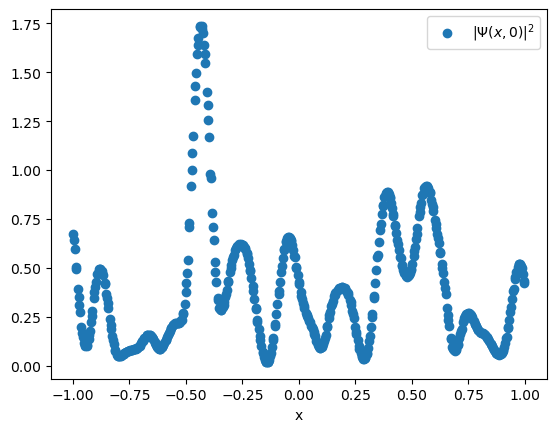

Best model saved to best_model_v0.keras at epoch 0
Best model saved to best_model_v0.keras at epoch 2
Best model saved to best_model_v0.keras at epoch 3
Best model saved to best_model_v0.keras at epoch 4
Best model saved to best_model_v0.keras at epoch 5
Best model saved to best_model_v0.keras at epoch 6
Best model saved to best_model_v0.keras at epoch 7
Best model saved to best_model_v0.keras at epoch 8
Best model saved to best_model_v0.keras at epoch 9
Best model saved to best_model_v0.keras at epoch 10
Best model saved to best_model_v0.keras at epoch 11
Best model saved to best_model_v0.keras at epoch 12
Best model saved to best_model_v0.keras at epoch 13
Best model saved to best_model_v0.keras at epoch 14
Best model saved to best_model_v0.keras at epoch 15
Best model saved to best_model_v0.keras at epoch 16
Best model saved to best_model_v0.keras at epoch 17
Best model saved to best_model_v0.keras at epoch 18
Best model saved to best_model_v0.keras at epoch 19
Best model saved to b

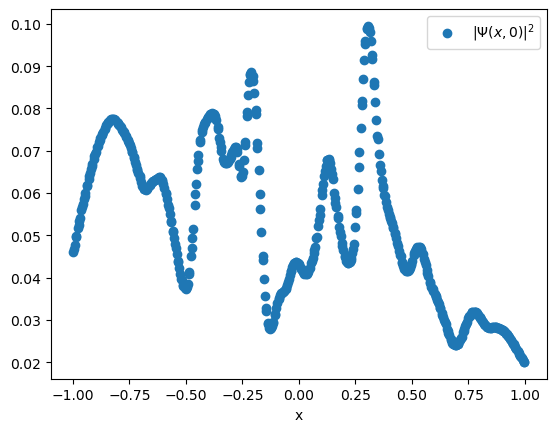

Best model saved to best_model_v0.keras at epoch 1051
Best model saved to best_model_v0.keras at epoch 1055
Best model saved to best_model_v0.keras at epoch 1060
Best model saved to best_model_v0.keras at epoch 1061
Best model saved to best_model_v0.keras at epoch 1062
Best model saved to best_model_v0.keras at epoch 1064
Best model saved to best_model_v0.keras at epoch 1068
Best model saved to best_model_v0.keras at epoch 1069
Best model saved to best_model_v0.keras at epoch 1070
Best model saved to best_model_v0.keras at epoch 1105
Best model saved to best_model_v0.keras at epoch 1139
Best model saved to best_model_v0.keras at epoch 1186
Best model saved to best_model_v0.keras at epoch 1238
Best model saved to best_model_v0.keras at epoch 1244
Best model saved to best_model_v0.keras at epoch 1271
Best model saved to best_model_v0.keras at epoch 1453
Best model saved to best_model_v0.keras at epoch 1480
Best model saved to best_model_v0.keras at epoch 1594
Best model saved to best_mod

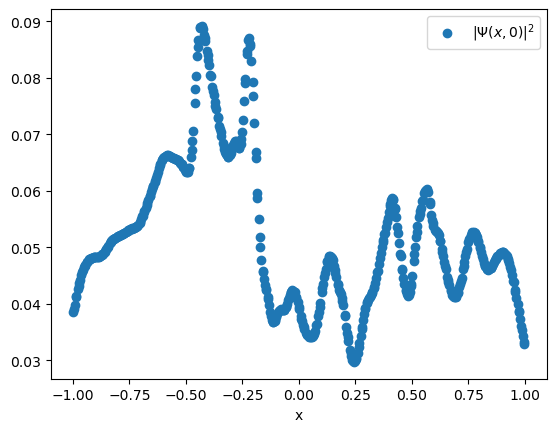

Best model saved to best_model_v0.keras at epoch 2012
Best model saved to best_model_v0.keras at epoch 2013
Best model saved to best_model_v0.keras at epoch 2021
Best model saved to best_model_v0.keras at epoch 2024
Best model saved to best_model_v0.keras at epoch 2035
Best model saved to best_model_v0.keras at epoch 2083
Best model saved to best_model_v0.keras at epoch 2087
Best model saved to best_model_v0.keras at epoch 2108
Best model saved to best_model_v0.keras at epoch 2110
Best model saved to best_model_v0.keras at epoch 2214
Best model saved to best_model_v0.keras at epoch 2215
Best model saved to best_model_v0.keras at epoch 2220
Best model saved to best_model_v0.keras at epoch 2223
Epoch 3000: Loss = 8.63616e-01 (f = 3.978e-02,               b = 4.105e-03, i = 8.007e-01, norm_p = 1.907e-02)


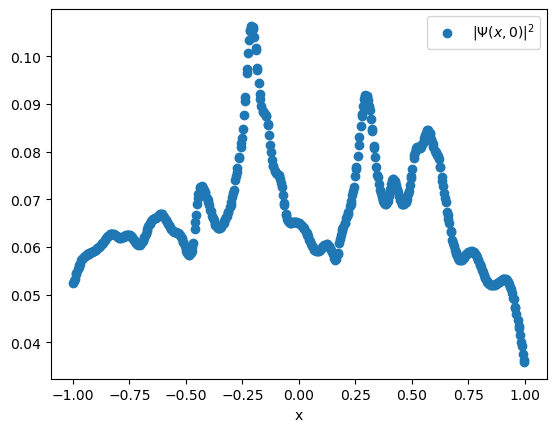

Best model saved to best_model_v0.keras at epoch 3020
Best model saved to best_model_v0.keras at epoch 3025
Best model saved to best_model_v0.keras at epoch 3028
Best model saved to best_model_v0.keras at epoch 3034
Best model saved to best_model_v0.keras at epoch 3035
Best model saved to best_model_v0.keras at epoch 3041
Best model saved to best_model_v0.keras at epoch 3042
Epoch 4000: Loss = 7.68650e-01 (f = 1.371e-02,               b = 1.308e-03, i = 7.488e-01, norm_p = 4.842e-03)


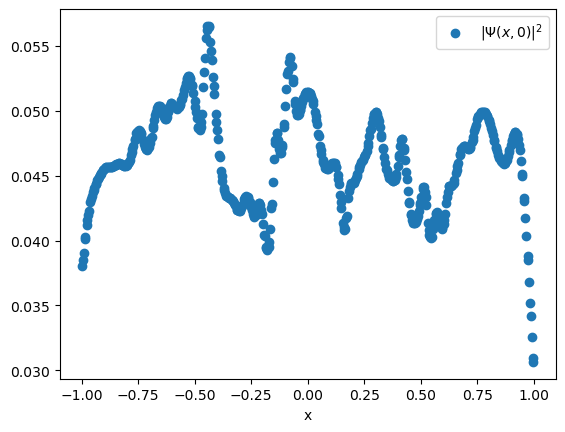

Best model saved to best_model_v0.keras at epoch 4037
Best model saved to best_model_v0.keras at epoch 4039
Best model saved to best_model_v0.keras at epoch 4041
Best model saved to best_model_v0.keras at epoch 4044
Best model saved to best_model_v0.keras at epoch 4082
Best model saved to best_model_v0.keras at epoch 4089
Best model saved to best_model_v0.keras at epoch 4092
Best model saved to best_model_v0.keras at epoch 4093
Best model saved to best_model_v0.keras at epoch 4097
Best model saved to best_model_v0.keras at epoch 4101
Best model saved to best_model_v0.keras at epoch 4103
Best model saved to best_model_v0.keras at epoch 4137
Best model saved to best_model_v0.keras at epoch 4138
Best model saved to best_model_v0.keras at epoch 4139
Best model saved to best_model_v0.keras at epoch 4141


OSError: [Errno 22] Invalid argument: 'best_model_v0.keras'

In [4]:
#############################################################################

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 1000
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": [],
    "norm_penalty": []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_v0.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li, norm_penalty) = train_step(pinn, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega, x_grid)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())
    train_loss_results["norm_penalty"].append(norm_penalty.numpy())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, \
              b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e}, norm_p = {norm_penalty.numpy().item():.3e})")

        X = tf.concat([x_i, t_i], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$')
        plt.xlabel('x')
        plt.legend()
        plt.show()

        # if epoch > 0:
        #     elapsed = time.time() - start_time
        #     eta = (elapsed/epoch) * (epoch + patience_counter)
        #     eta_formatted = str(datetime.timedelta(seconds=int(eta-elapsed)))
        #     print(f"Estimated time remaining: {eta_formatted}")
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm_penalty"], label="Norm Penalty")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

# Check prediction consistency
x_test = np.linspace(x_min, x_max, 100).reshape(-1,1).astype(np.float64)
x_test = scale_inputs(x_test, x_min, x_max)
t_test = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float64)
t_test = scale_inputs(t_test, t_min, t_max)

x_test_tensor = tf.convert_to_tensor(x_test)
t_test_tensor = tf.convert_to_tensor(t_test)

original_prediction = pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
    print("Predictions do not match after loading!")
else:
    print("Predictions match.")

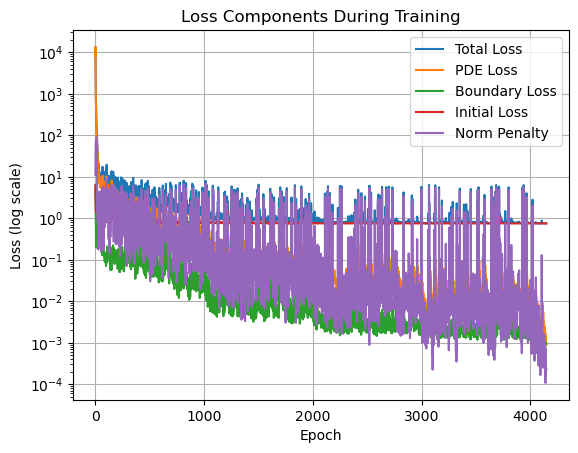

In [5]:
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm_penalty"], label="Norm Penalty")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

In [ ]:
################################################## Loading the model ###########################################################3

Normalization check for the initial condition: $|\Psi(x,0)|**2=0.9999999999999998$
Model loaded successfully


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_2         │ ?                      │         1,024 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (4096, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (4096, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (4096, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (4096, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (4096, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,818 (10.03 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,024 (8.00 KB)

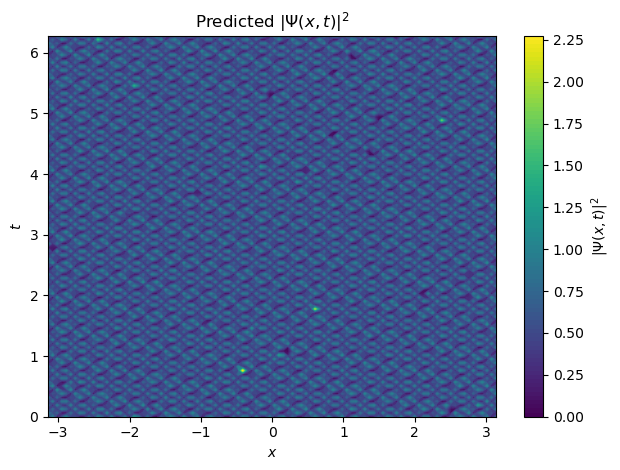

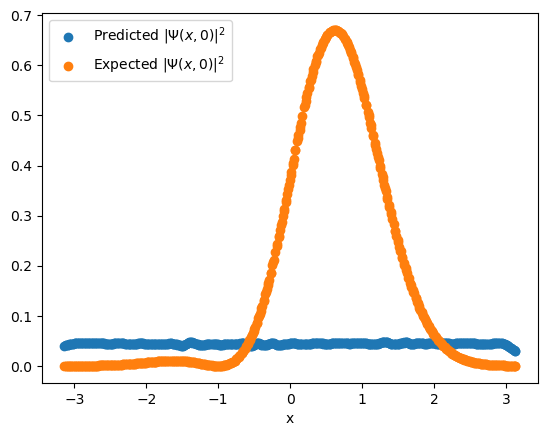

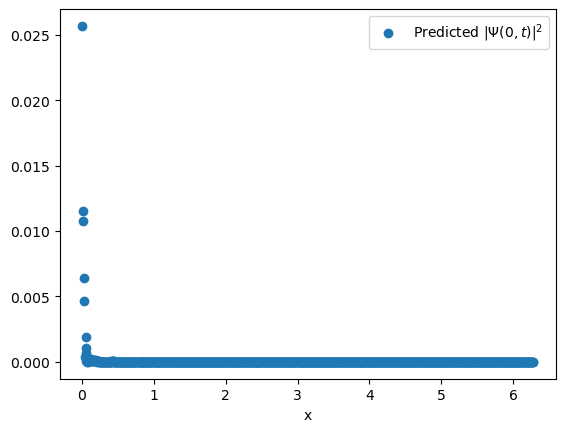

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.qmc import Sobol

import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def generate_sobol_points(n_points, x_bounds, t_bounds):
    sampler = Sobol(d=2, scramble=True)
    sobol_sample = sampler.random(n=n_points)

    x_sobol = x_bounds[0].numpy() + (x_bounds[1].numpy() - x_bounds[0].numpy()) * sobol_sample[:, 0]
    t_sobol = t_bounds[0].numpy() + (t_bounds[1].numpy() - t_bounds[0].numpy()) * sobol_sample[:, 1]

    return tf.convert_to_tensor(x_sobol, dtype=DTYPE), tf.convert_to_tensor(t_sobol, dtype=DTYPE)

def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2) * x * tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500

# interior points
x_f, t_f = generate_sobol_points(N_f, (x_min, x_max), (t_min, t_max))
# scaled interior points
x_f_scaled = scale_inputs(x_f, x_min, x_max)
t_f_scaled = scale_inputs(t_f, t_min, t_max)

# boundary points
x_lb, t_lb = generate_sobol_points(N_b, (x_min, x_min), (t_min, t_max))
x_rb, t_rb = generate_sobol_points(N_b, (x_max, x_max), (t_min, t_max))
x_b = tf.concat([x_lb, x_rb], axis=0)
t_b = tf.concat([t_lb, t_rb], axis=0)
# scaled boundary points
x_lb_scaled = scale_inputs(x_lb, x_min, x_max)
t_lb_scaled = scale_inputs(t_lb, t_min, t_max)
x_rb_scaled = scale_inputs(x_rb, x_min, x_max)
t_rb_scaled = scale_inputs(t_rb, t_min, t_max)

x_b_scaled = tf.concat([x_lb_scaled, x_rb_scaled], axis=0)
t_b_scaled = tf.concat([t_lb_scaled, t_rb_scaled], axis=0)

# initial points
x_i, t_i = generate_sobol_points(N_i, (x_min, x_max), (t_min, t_min))
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)
# scaled initial points
x_i_scaled = scale_inputs(x_i, x_min, x_max)
t_i_scaled = scale_inputs(t_i, t_min, t_max)
# # normalized psi_i (Monte Carlo integration)
# norm = tf.math.sqrt(tf.reduce_mean(tf.math.abs(psi_i)**2) * (x_max-x_min))
# psi_i_Re = tf.math.real(psi_i) / norm
# psi_i_Im = tf.math.imag(psi_i) / norm

# normalized psi_i (Riemann sum approximation)
dx_i = (x_max - x_min) / N_i
norm = tf.math.sqrt(tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i)
psi_i_Re = tf.math.real(psi_i) / norm
psi_i_Im = tf.math.imag(psi_i) / norm

# verify normalization
norm_check = tf.reduce_sum(psi_i_Re**2 + psi_i_Im**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# define Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model
loaded_model = tf.keras.models.load_model('best_model_v0.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

# Create a contour plot
x_plot = np.linspace(x_min, x_max, 100)
t_plot = np.linspace(t_min, t_max, 100)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

input = tf.stack([x_f_scaled, t_f_scaled], axis=1)
uv = loaded_model(input)
u, v = uv[:, 0], uv[:, 1]
density = u**2 + v**2
density_grid = tf.reshape(density, X_grid.shape)

# # Convert tensors to numpy for plotting
# X_plot_np = X_grid.np()
# T_plot_np = T_grid.np()
density_grid_np = density_grid.numpy()


# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_grid_np, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Predicted $|\Psi(x,t)|^2$')
plt.tight_layout()
plt.show()

# test points
t_test = tf.keras.ops.full_like(x_i, 0.2, dtype=DTYPE)
t_test_scaled = scale_inputs(t_test, t_min, t_max)

X = tf.stack([x_i_scaled, t_i_scaled], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
density = u**2 + v**2

X_test = tf.stack([x_i_scaled, t_test_scaled], axis=1)
uv = loaded_model(X_test)
u, v = uv[:, 0:1], uv[:, 1:2]
density_test = u**2 + v**2

plt.scatter(x_i, density, label=r'Predicted $|\Psi(x,0)|^2$')
# plt.scatter(x_i, density_test, label=f'Predicted $|\Psi(x,{t_test[0,0].numpy()})|^2$')
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

X = tf.stack([x_b_scaled, t_b_scaled], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
density = u**2 + v**2

density_bounds = tf.keras.ops.full_like(t_b, 0.0, dtype=DTYPE)

plt.scatter(t_b, density, label=r'Predicted $|\Psi(0,t)|^2$')
plt.scatter(t_b, density_bounds, label=r'Expected $|\Psi(0,t)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

In [ ]:
################################################## 2 Loading the model ###########################################################

Normalization check for the initial condition: $|\Psi(x,0)|**2=1.0$
Model loaded successfully


Model: "pinn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_1         │ ?                      │         1,024 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (10000, 512)           │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (10000, 2)             │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,818 (10.03 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,024 (8.00 KB)

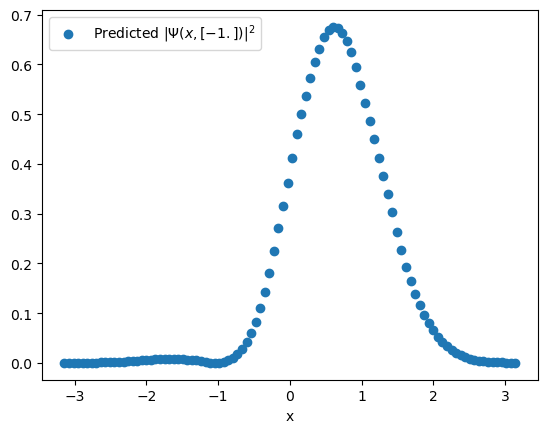

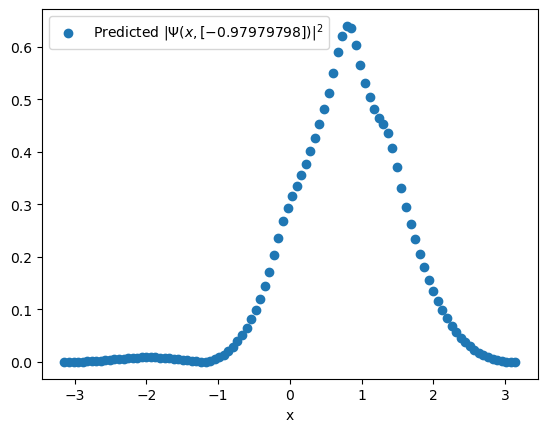

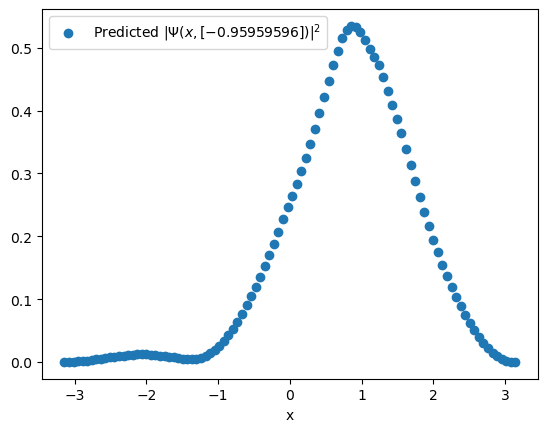

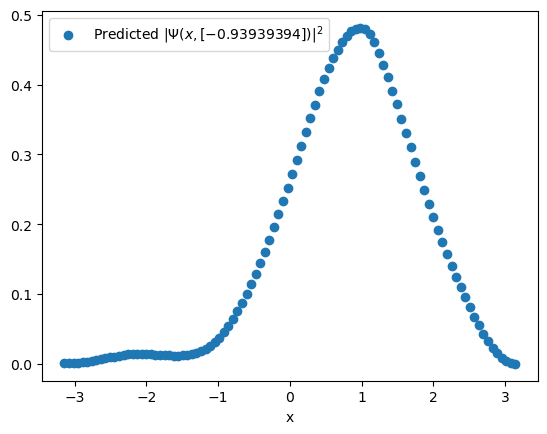

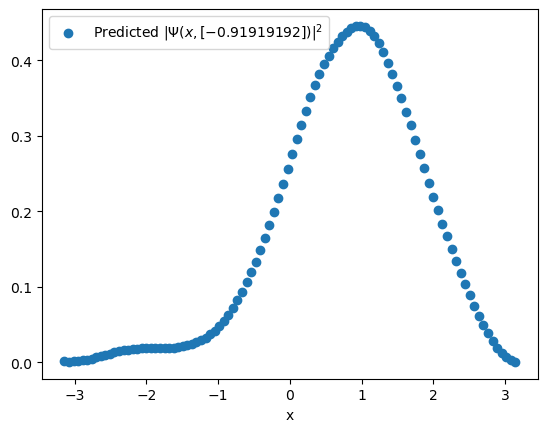

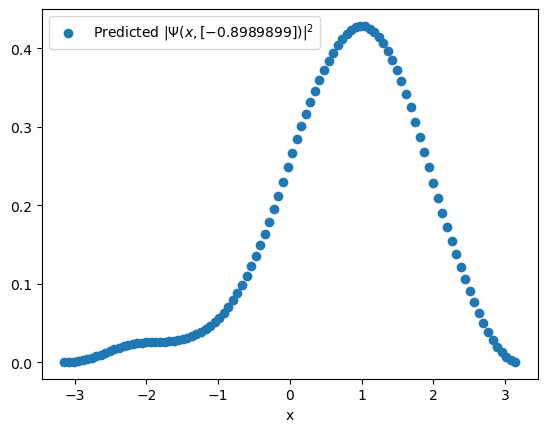

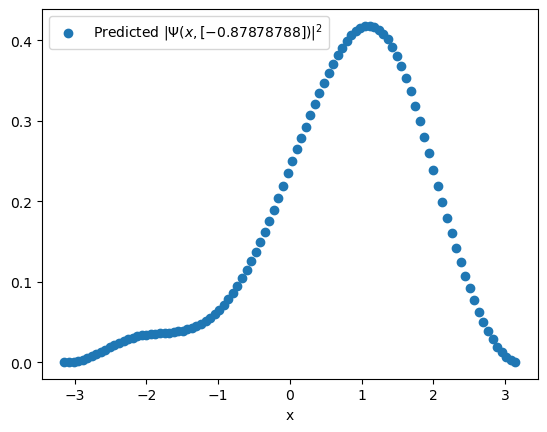

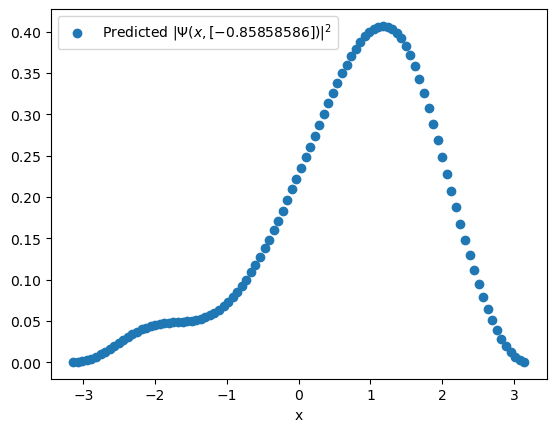

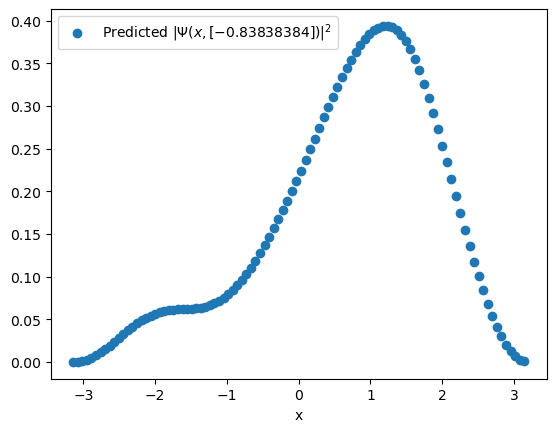

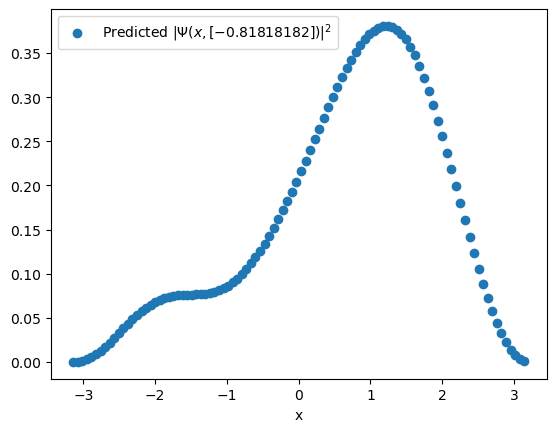

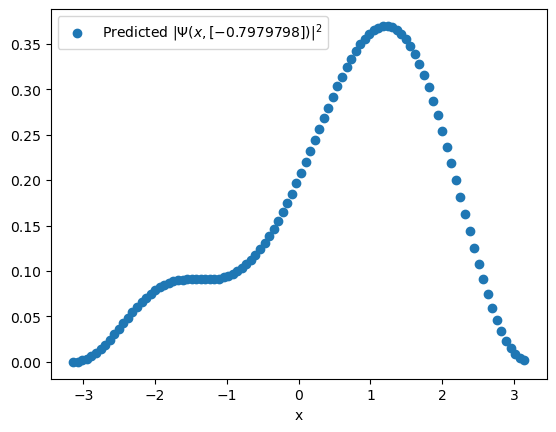

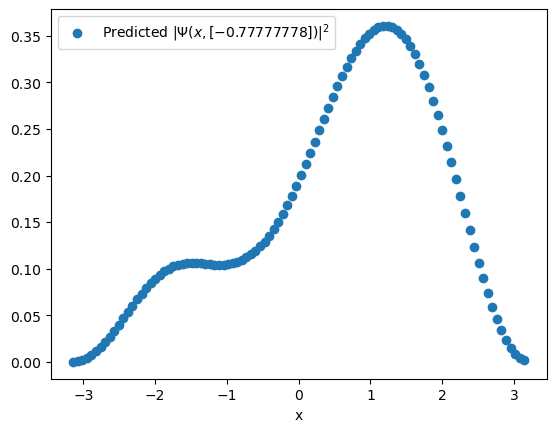

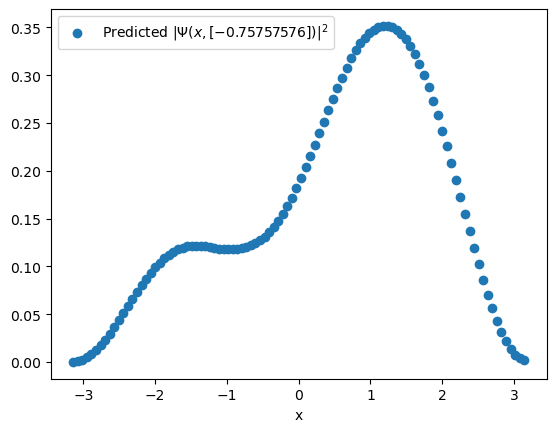

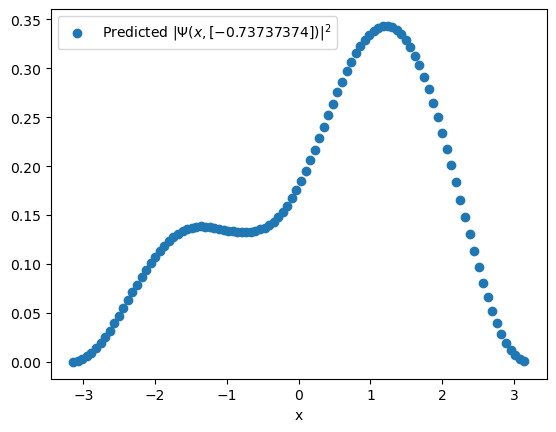

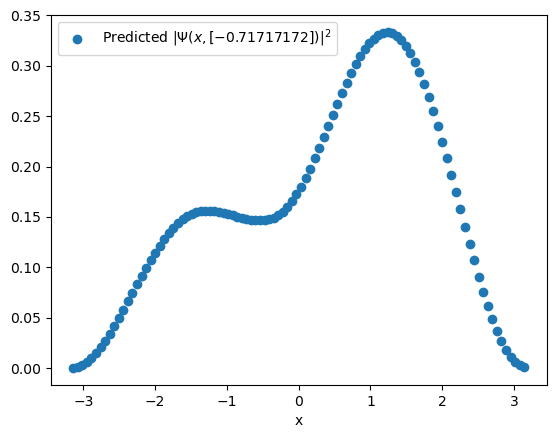

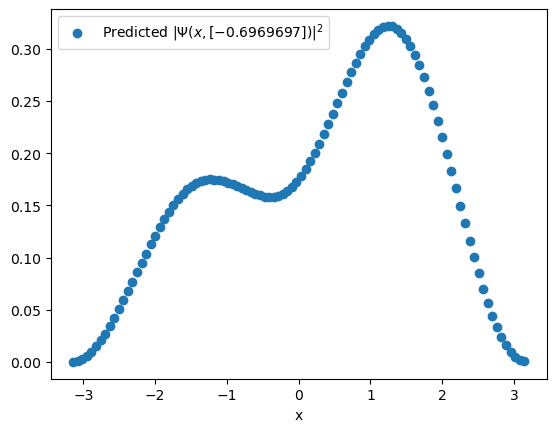

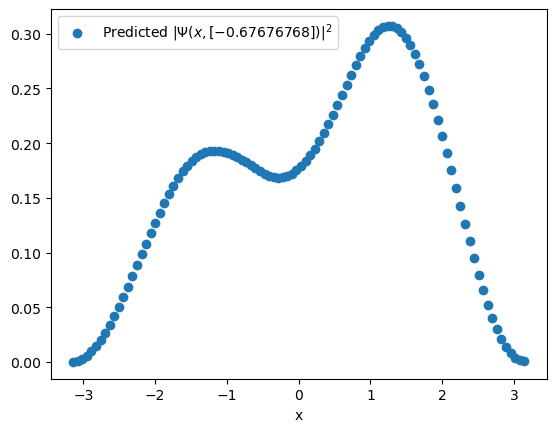

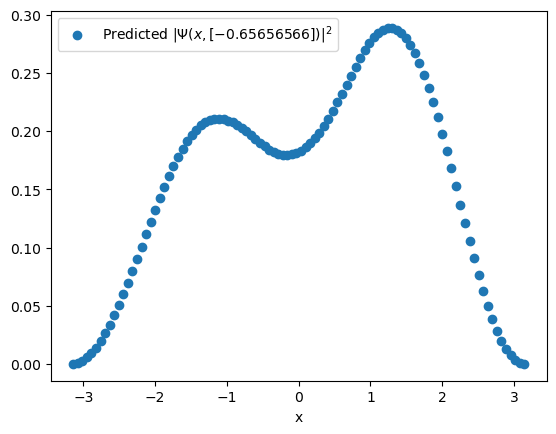

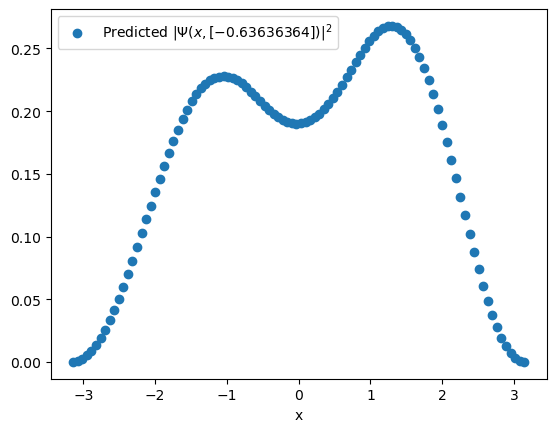

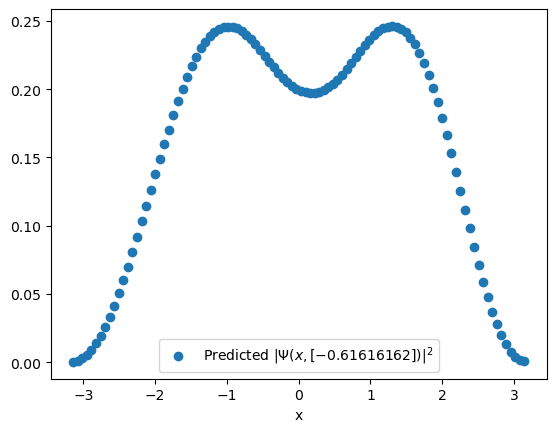

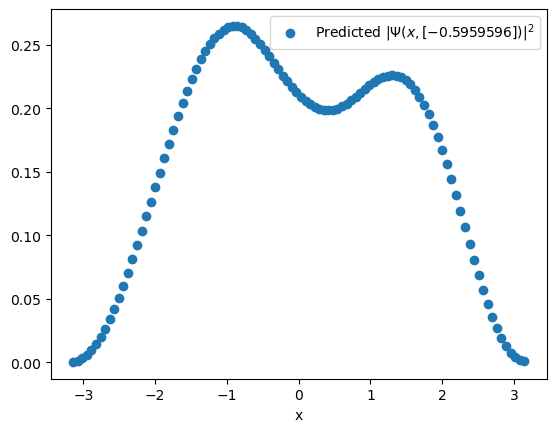

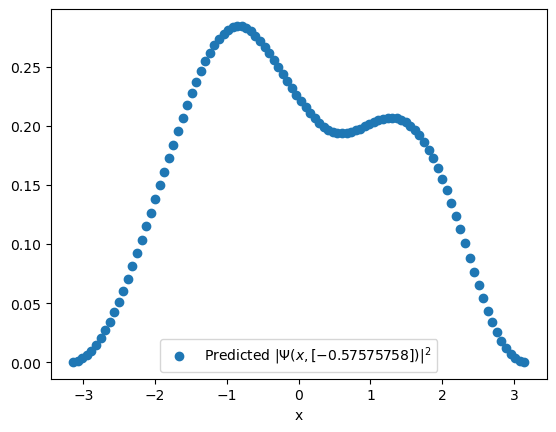

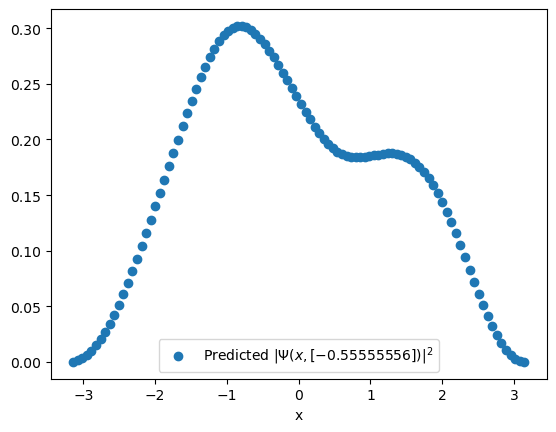

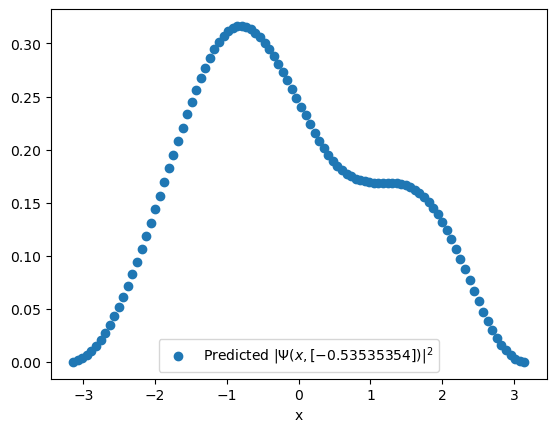

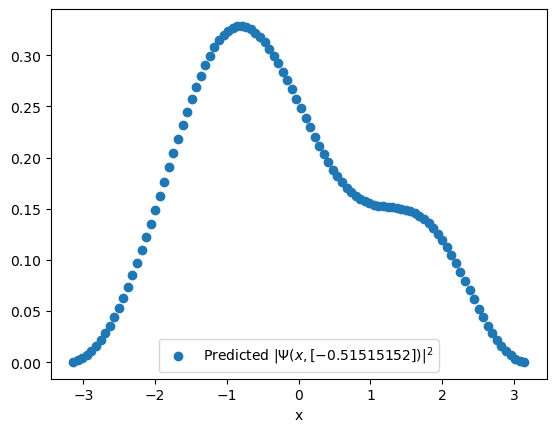

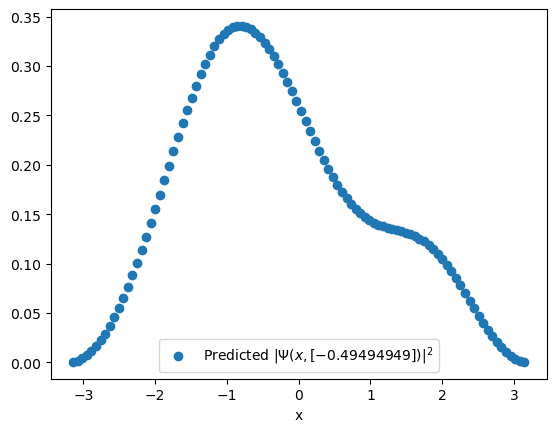

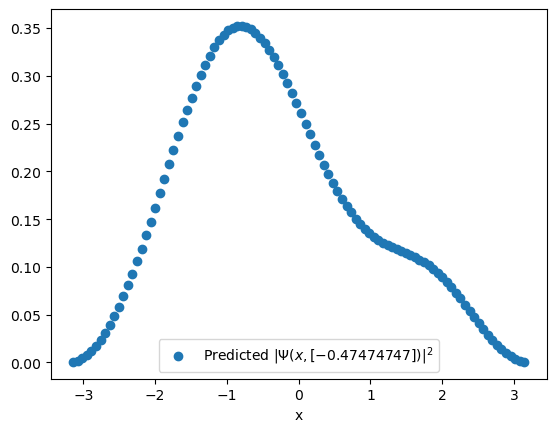

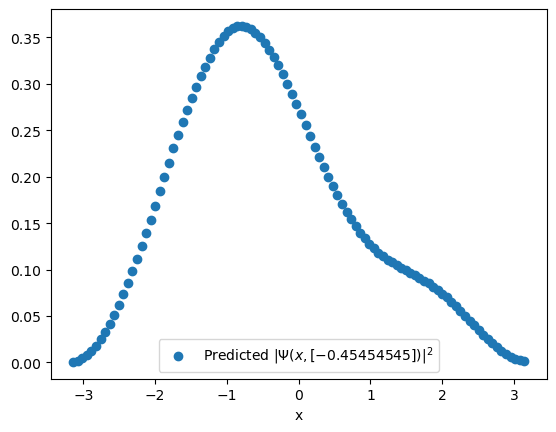

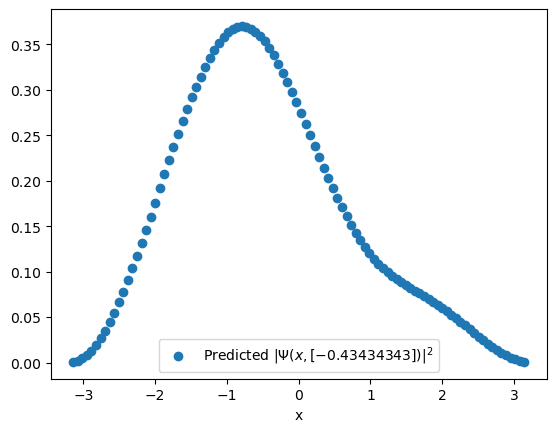

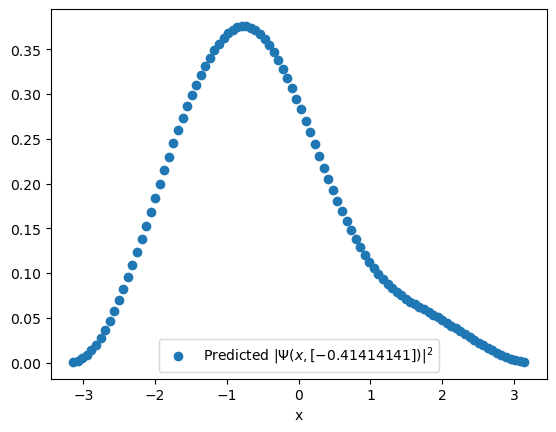

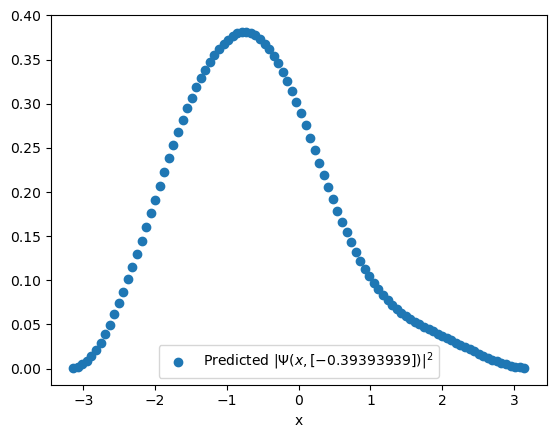

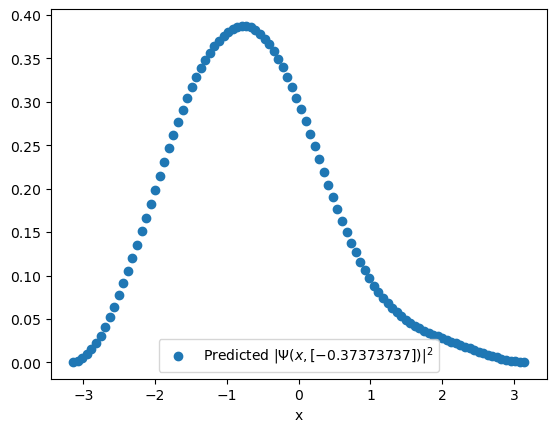

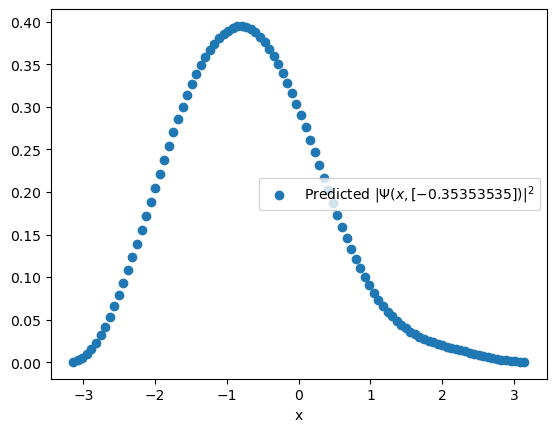

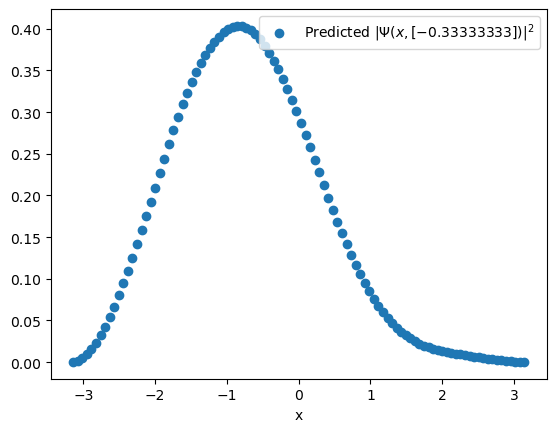

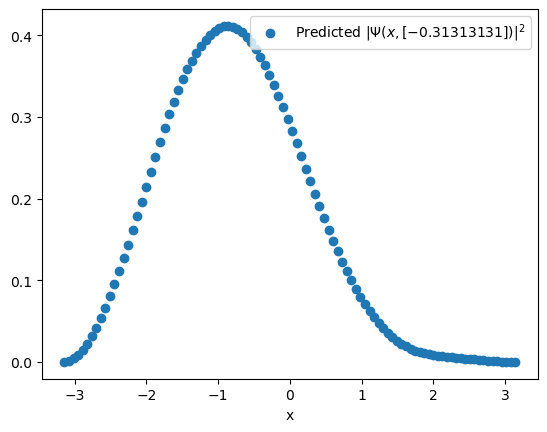

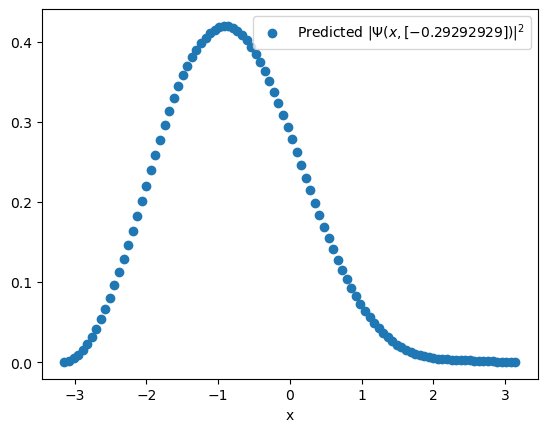

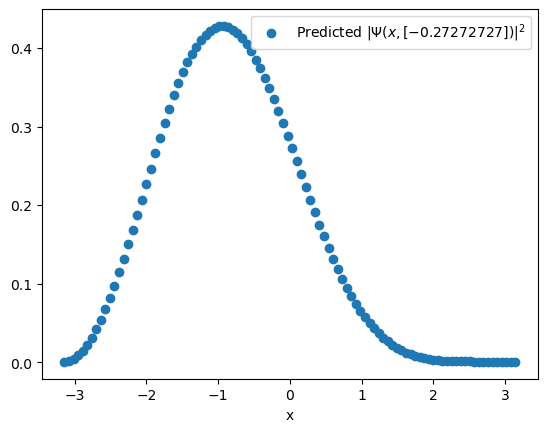

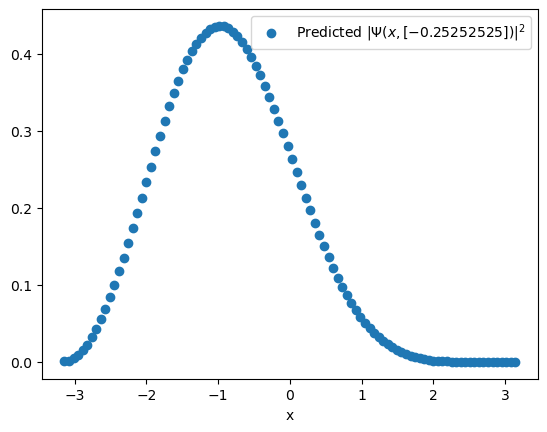

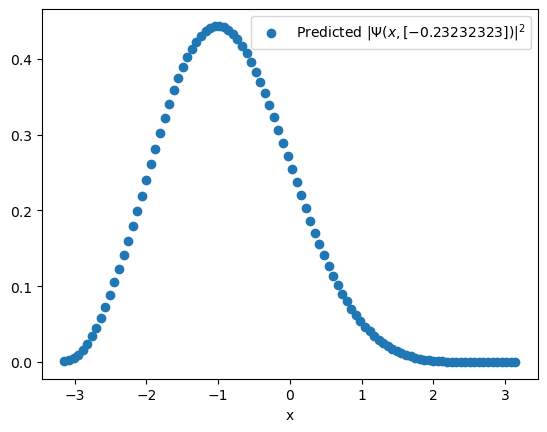

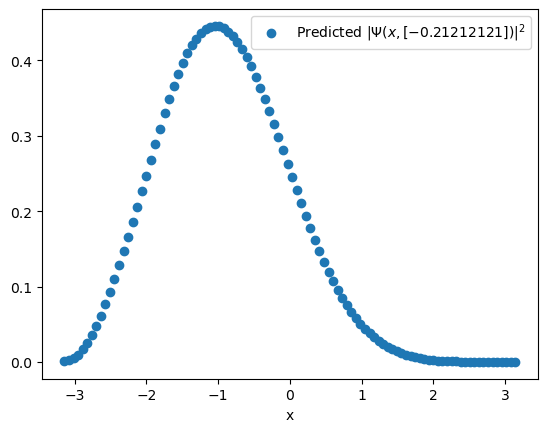

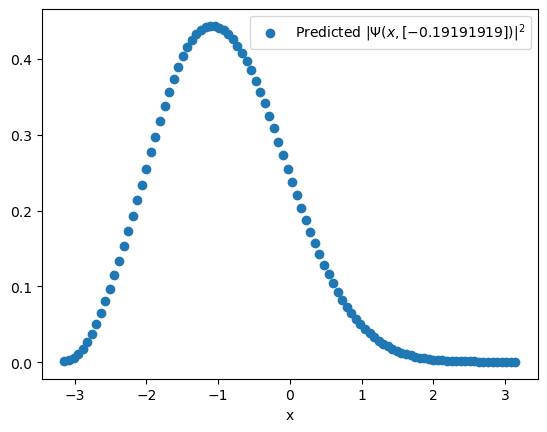

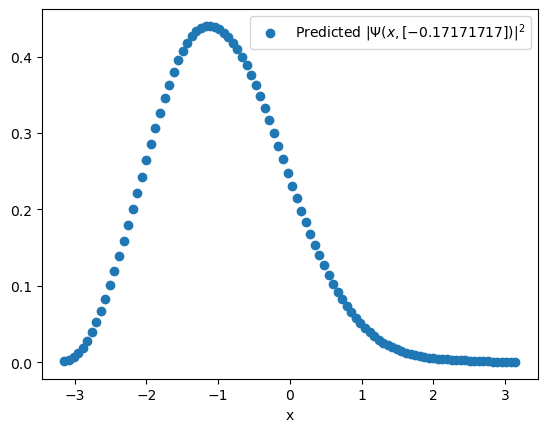

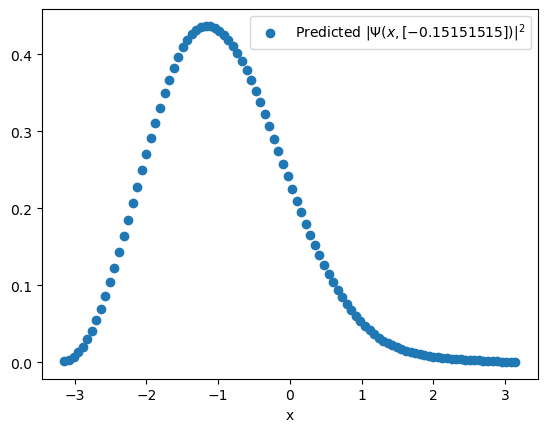

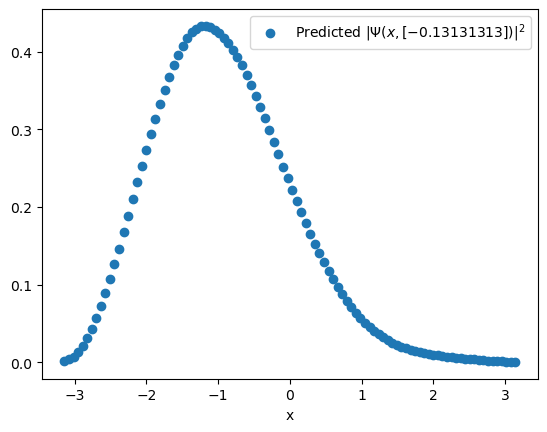

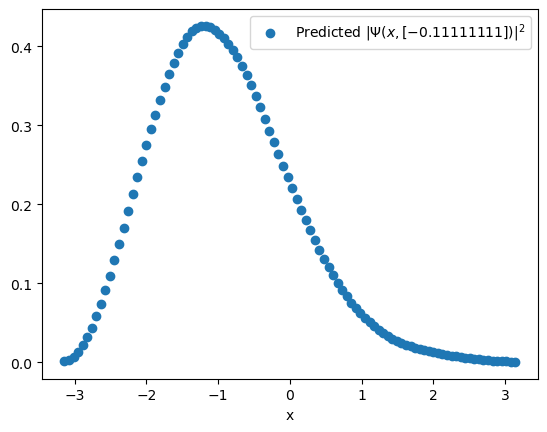

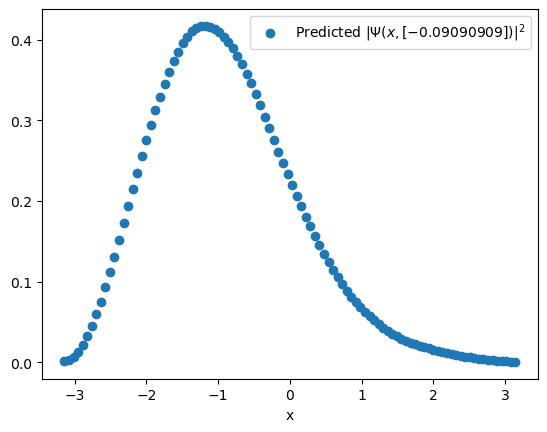

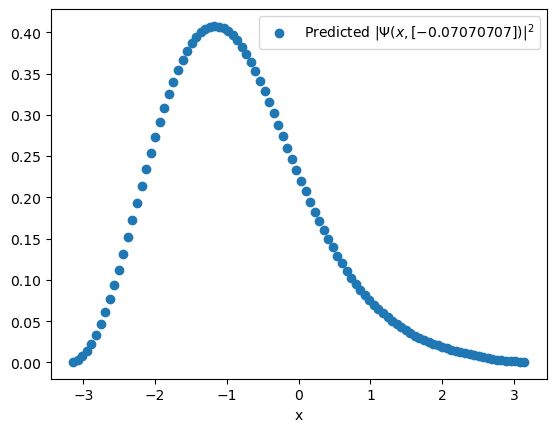

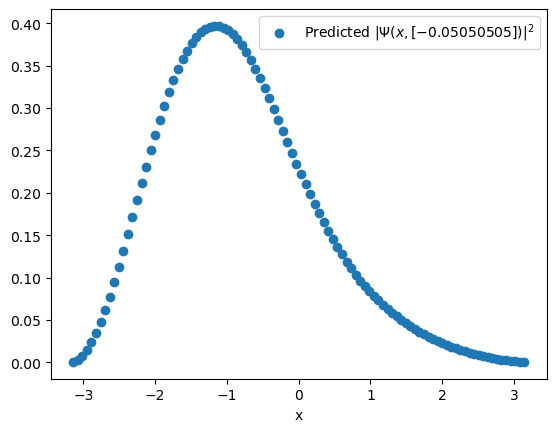

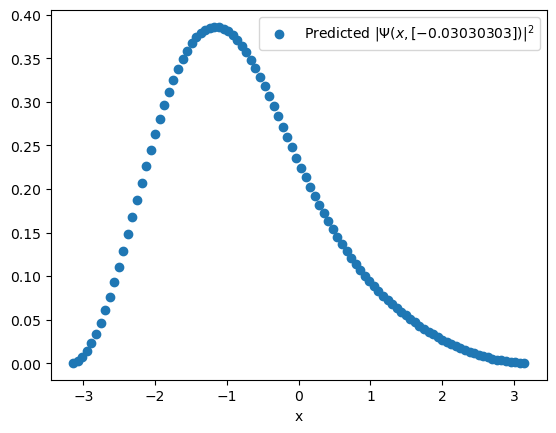

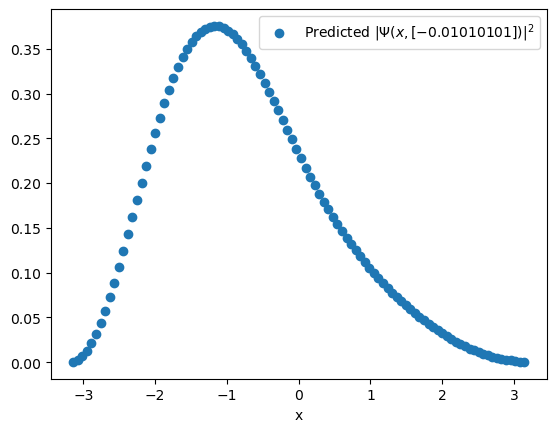

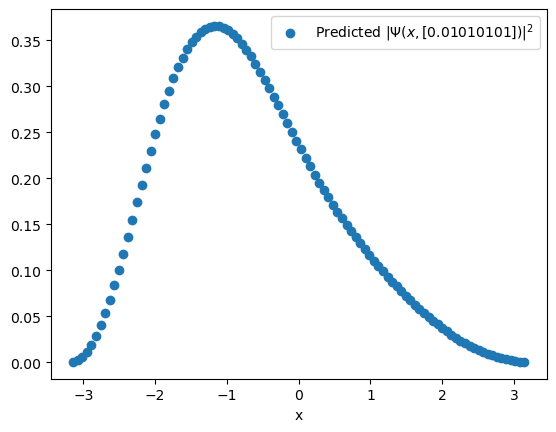

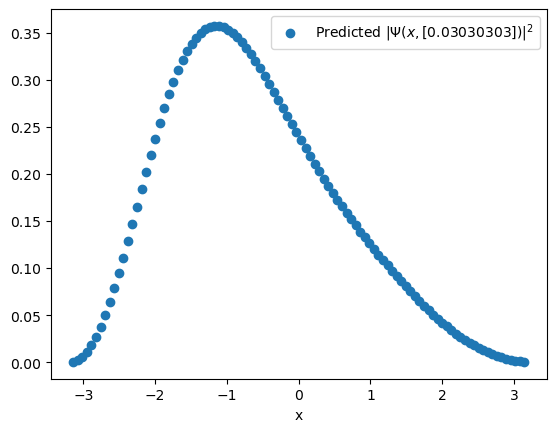

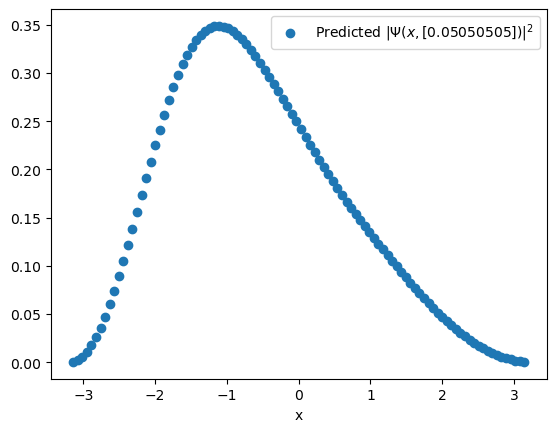

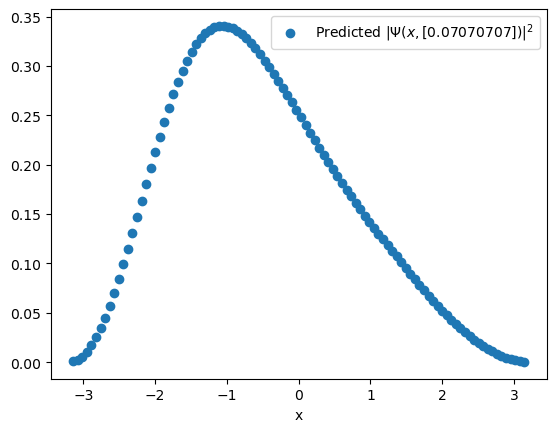

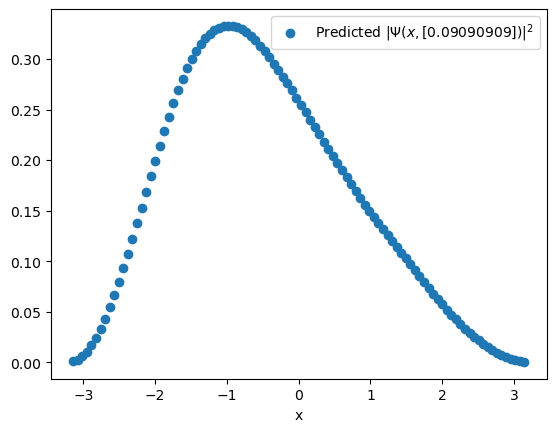

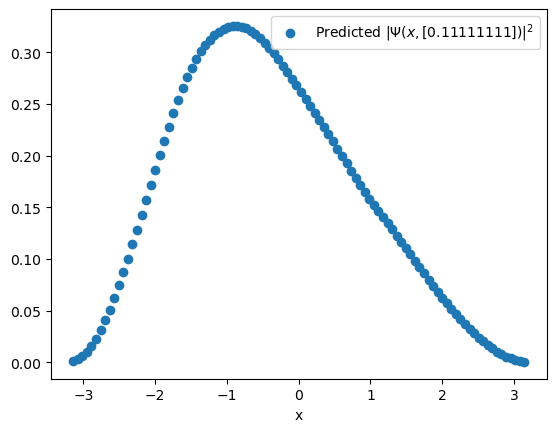

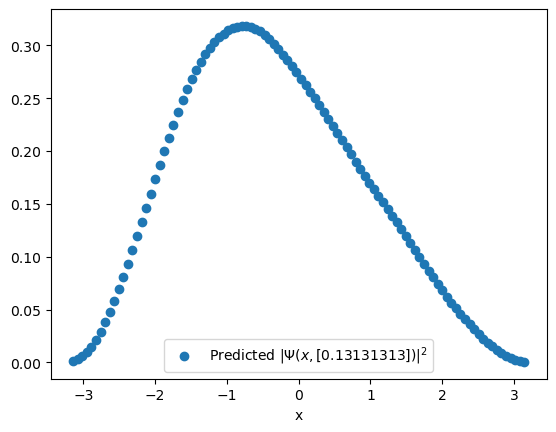

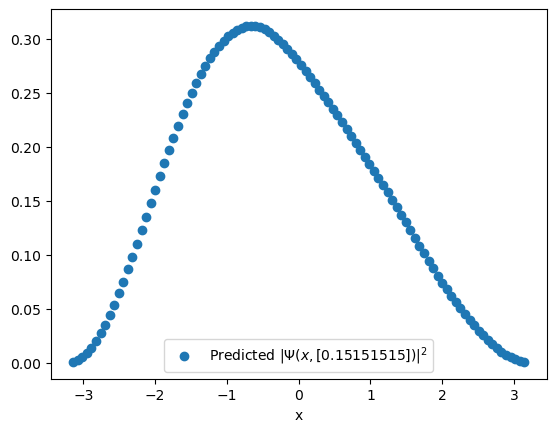

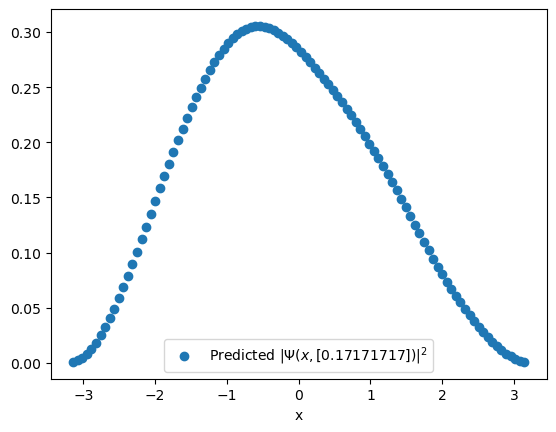

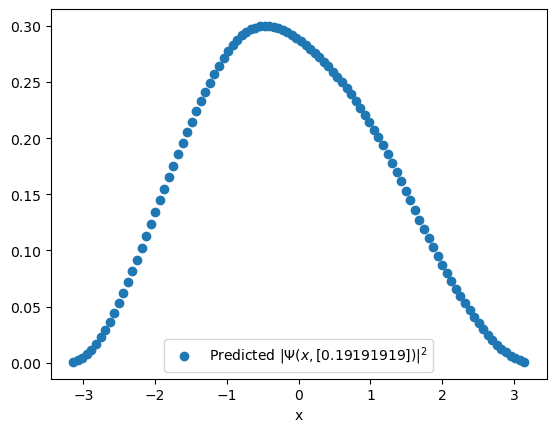

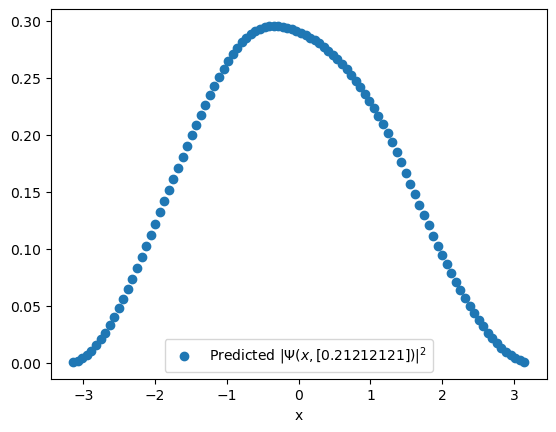

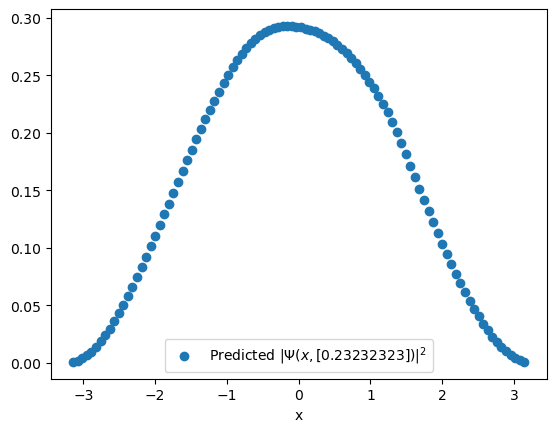

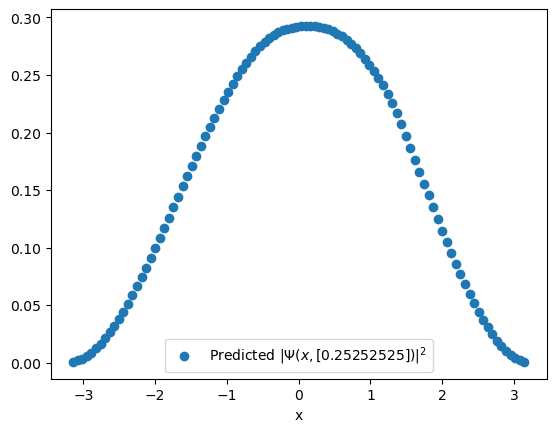

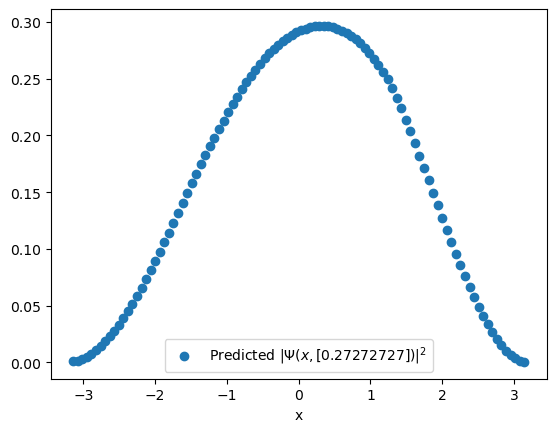

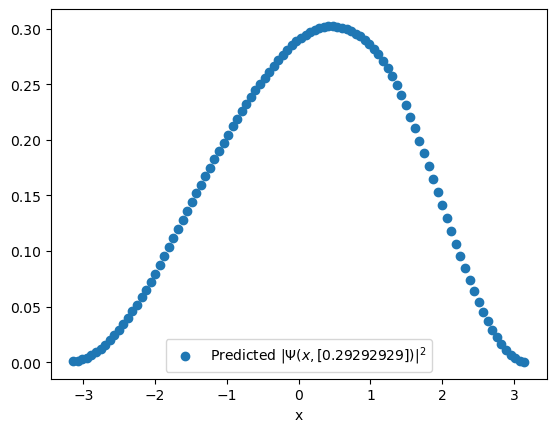

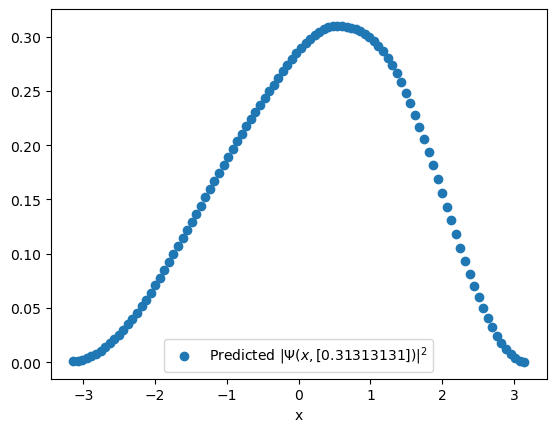

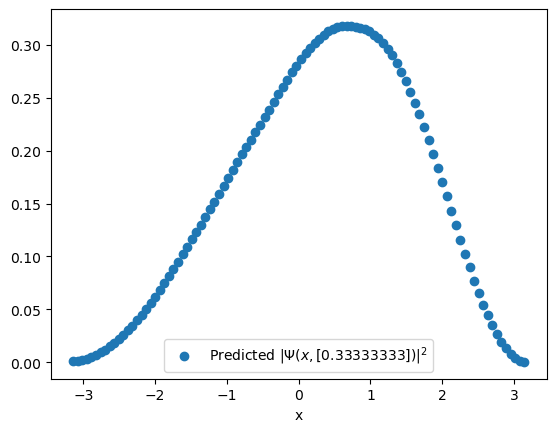

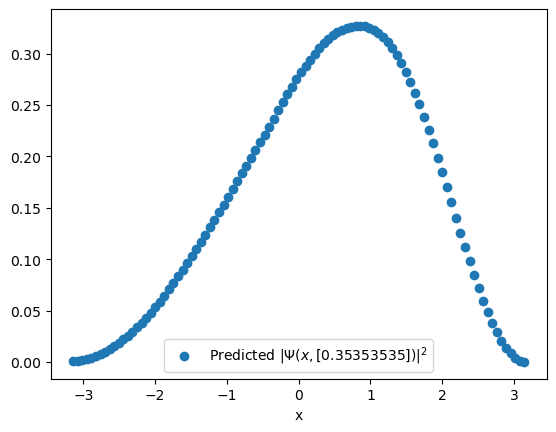

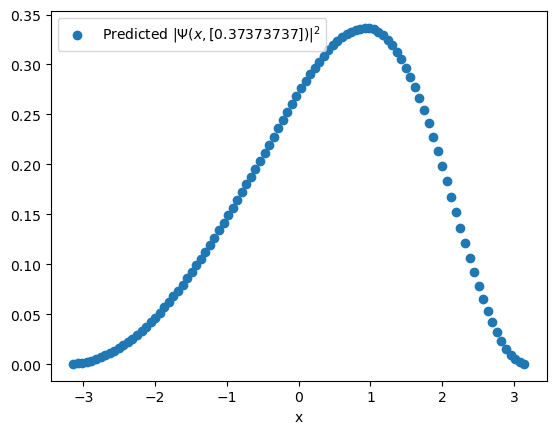

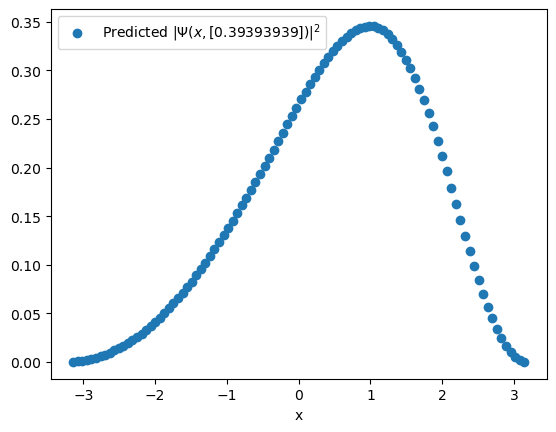

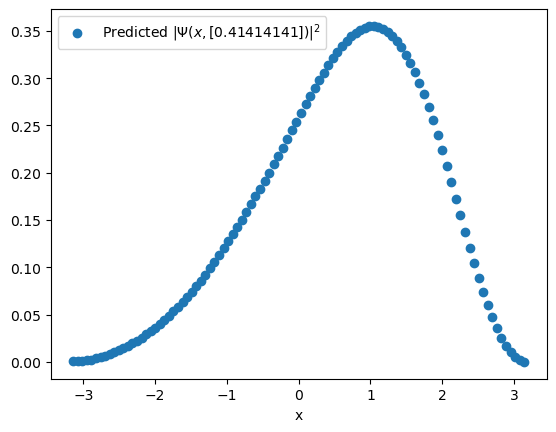

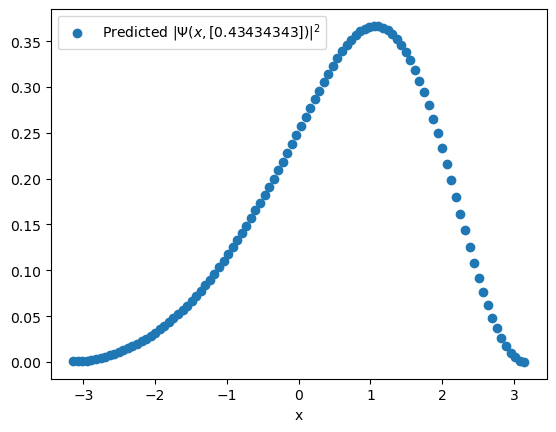

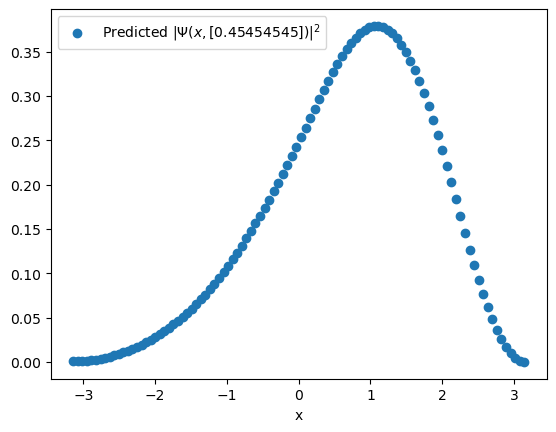

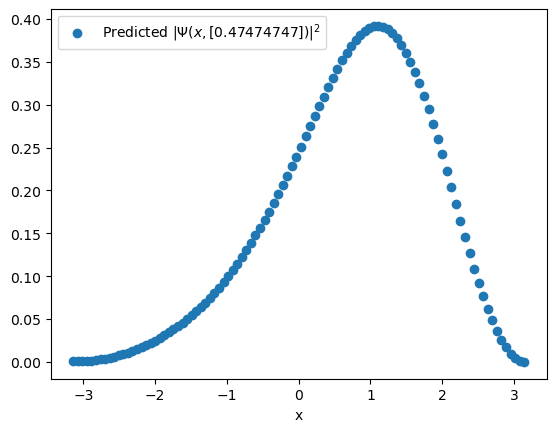

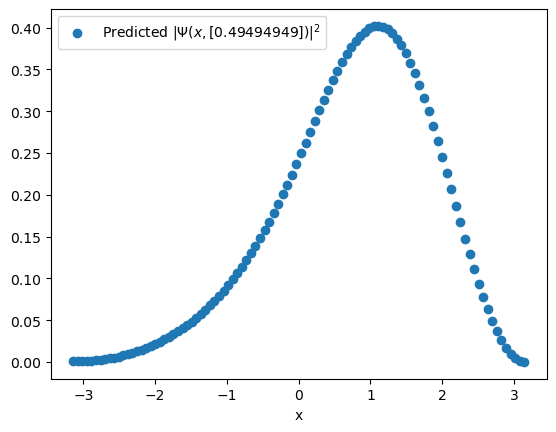

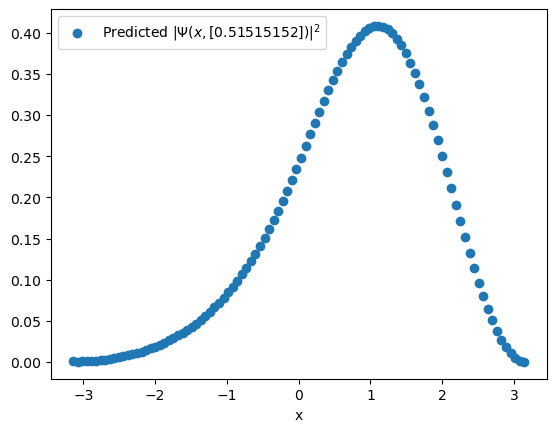

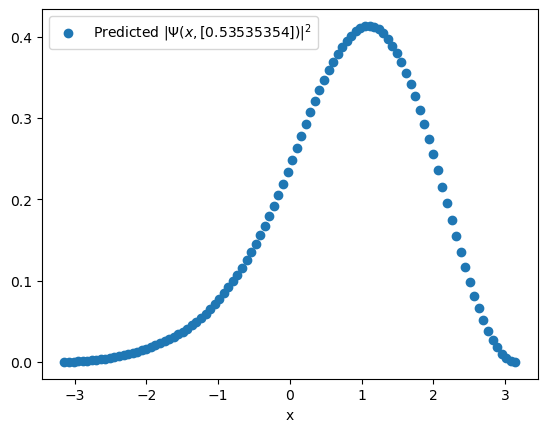

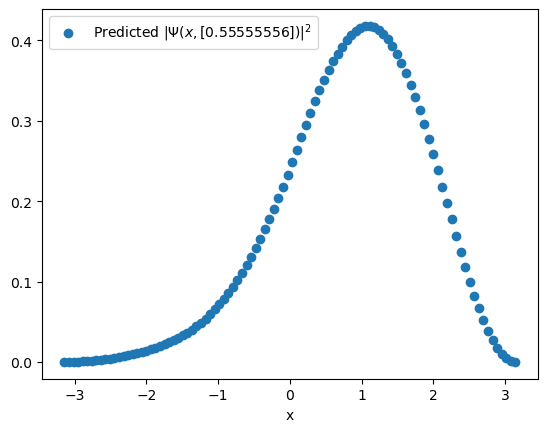

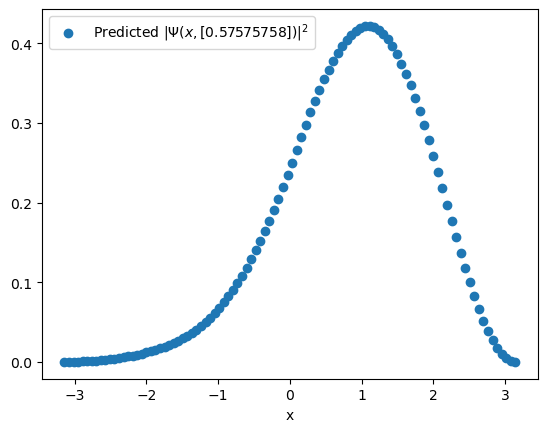

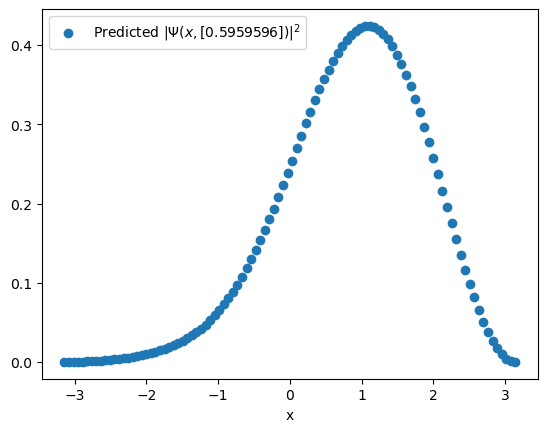

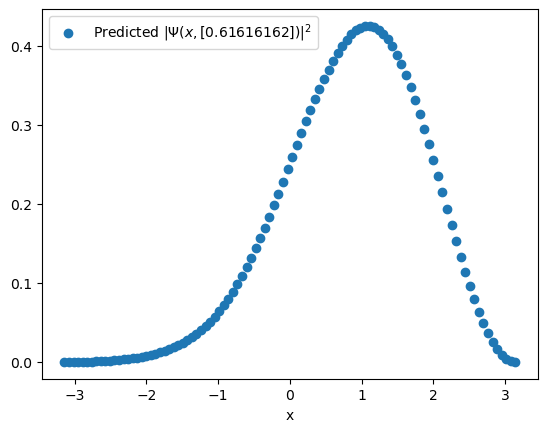

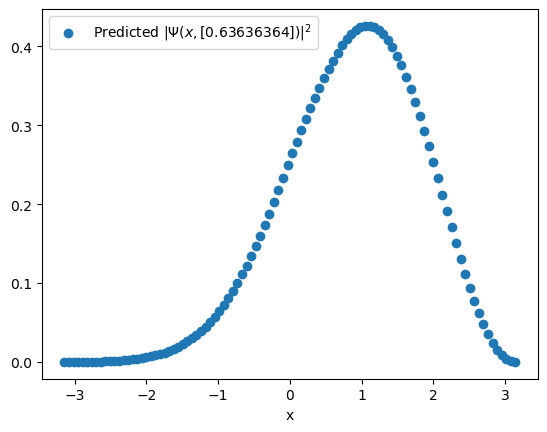

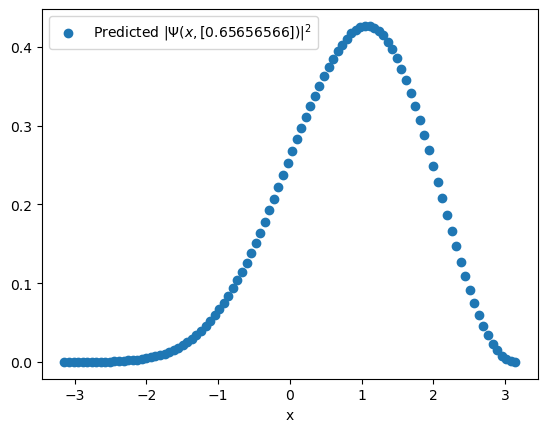

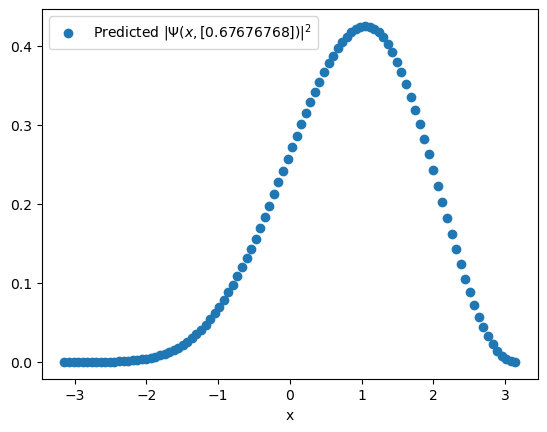

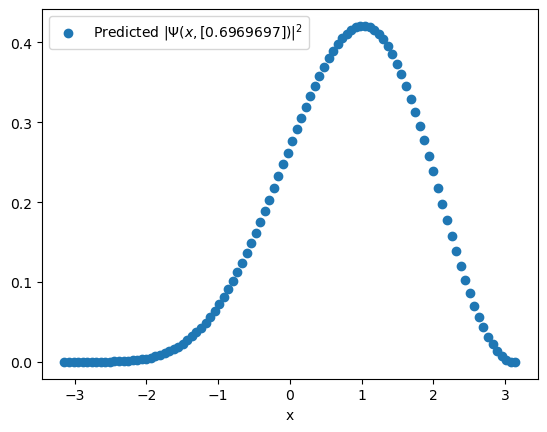

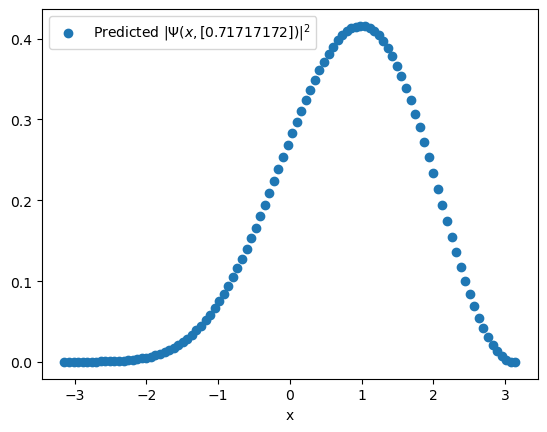

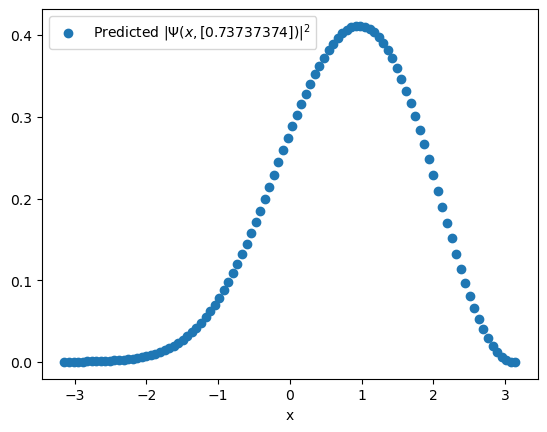

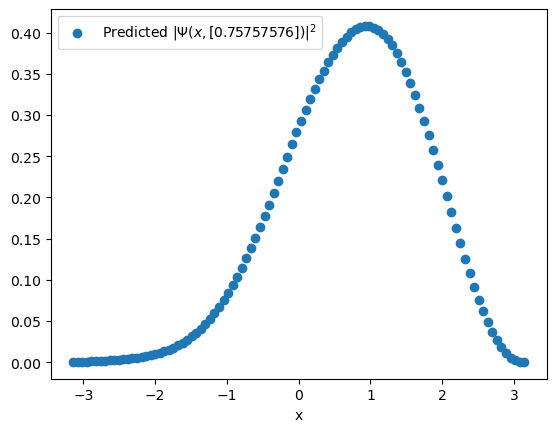

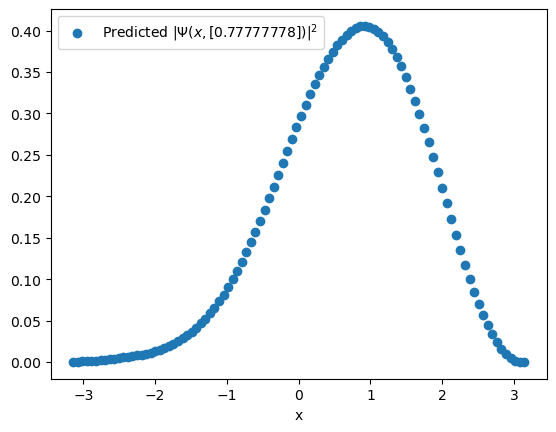

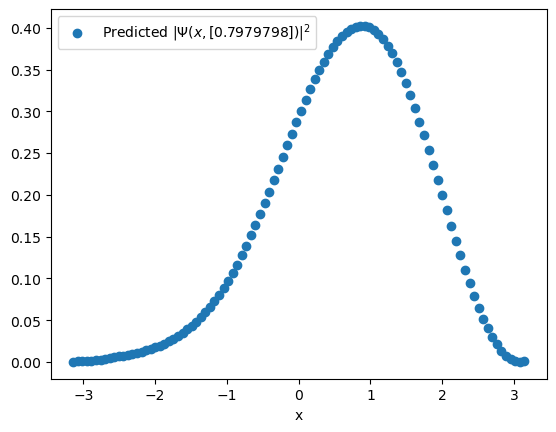

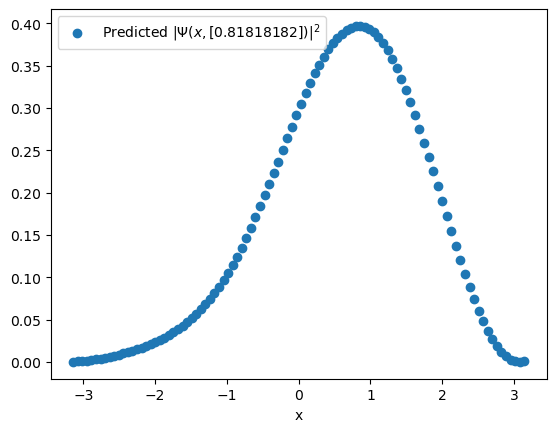

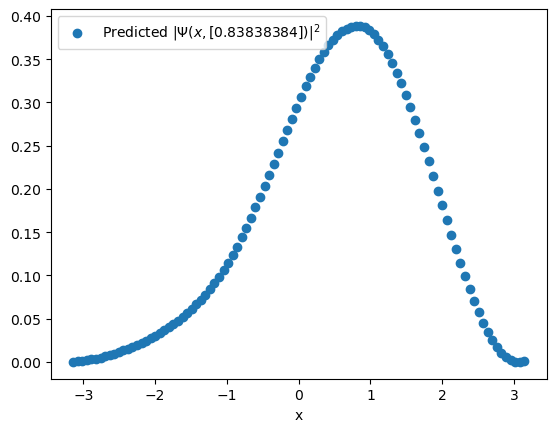

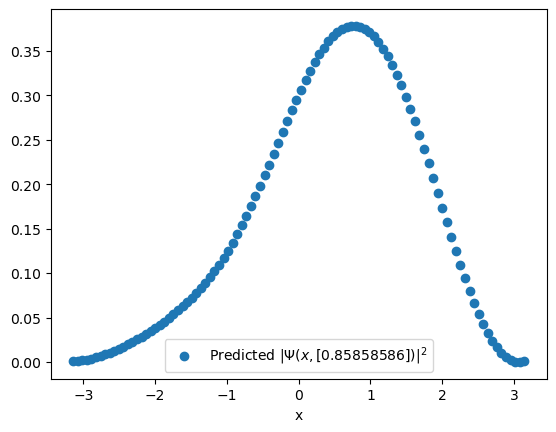

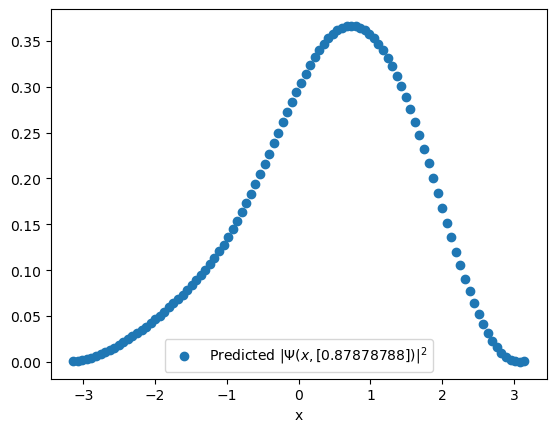

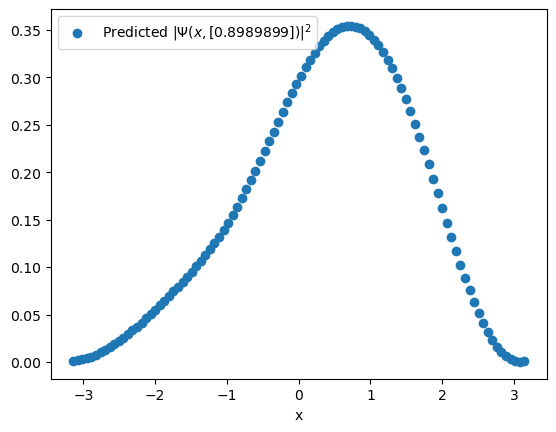

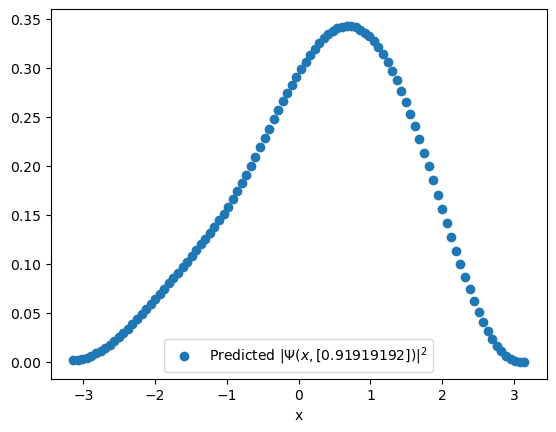

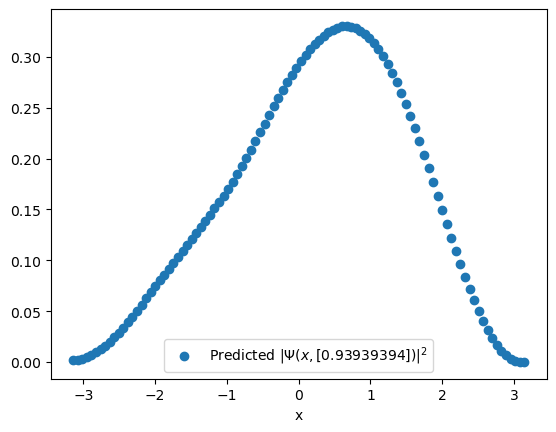

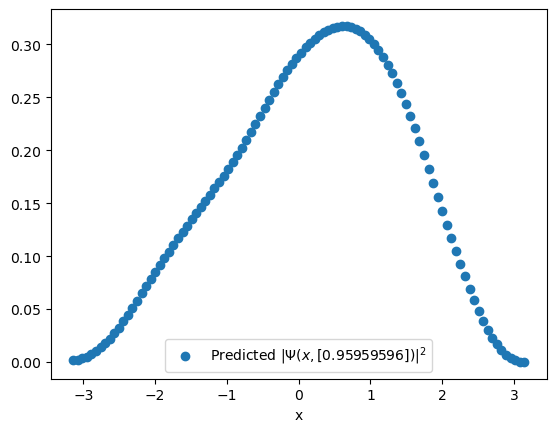

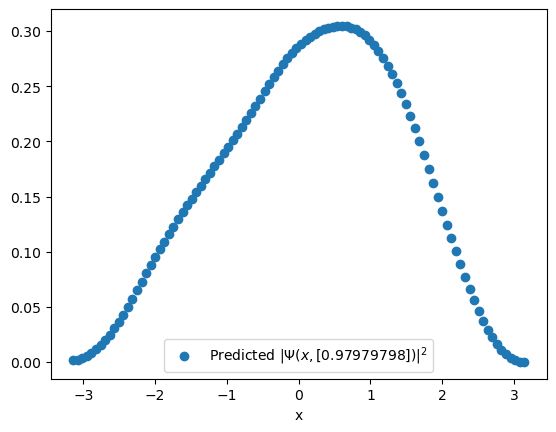

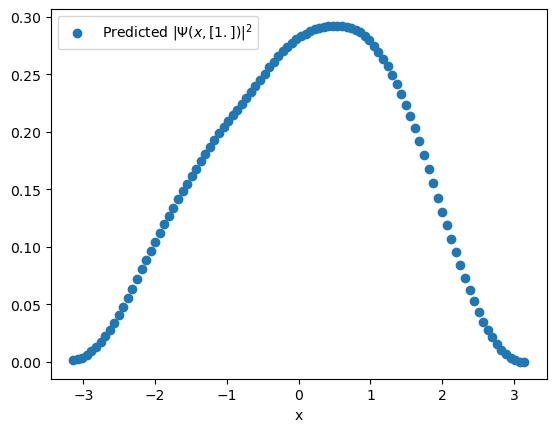

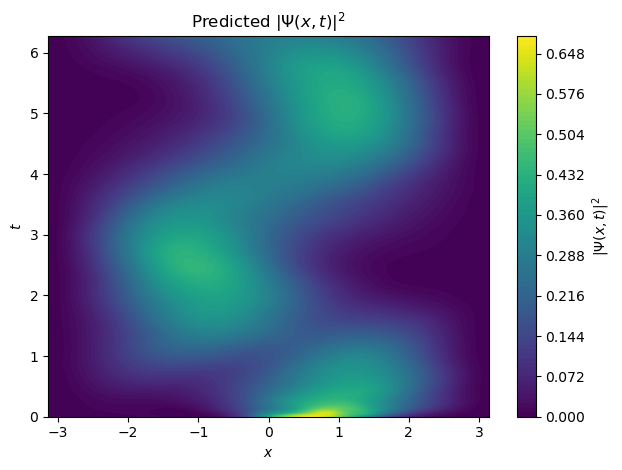

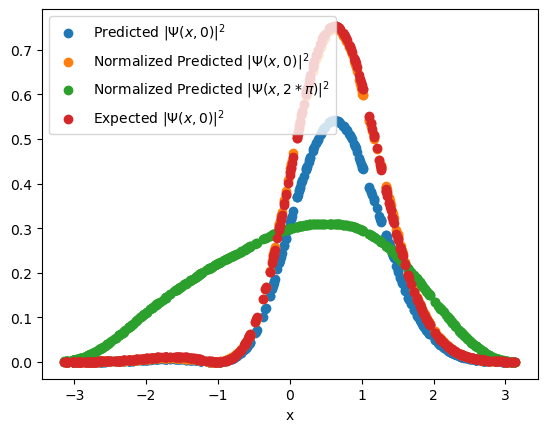

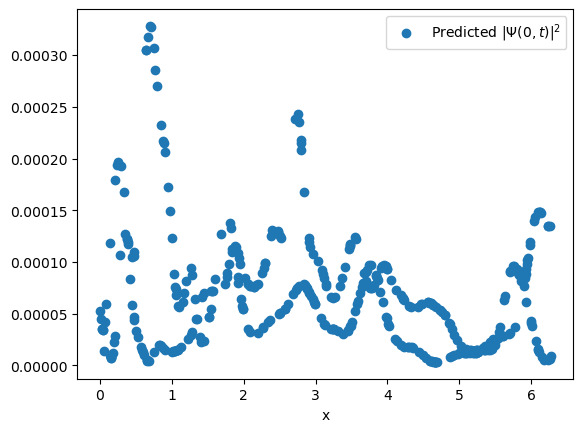

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2) * x * tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 400, 500

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
# scaled interior points
x_f_scaled = scale_inputs(x_f, x_min, x_max)
t_f_scaled = scale_inputs(t_f, t_min, t_max)

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
# scaled boundary points
x_b_scaled = scale_inputs(x_b, x_min, x_max)
t_b_scaled = scale_inputs(t_b, t_min, t_max)

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)
# scaled initial points
x_i_scaled = scale_inputs(x_i, x_min, x_max)
t_i_scaled = scale_inputs(t_i, t_min, t_max)

# normalized psi_i (Riemann sum approximation)
dx_i = (x_max - x_min) / N_i
norm = tf.math.sqrt(tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i)
psi_i_Re = tf.math.real(psi_i) / norm
psi_i_Im = tf.math.imag(psi_i) / norm

# verify normalization
norm_check = tf.reduce_sum(psi_i_Re**2 + psi_i_Im**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# define Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model
loaded_model = tf.keras.models.load_model('model_v4.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

# Create a contour plot
N = 100
x_plot = np.linspace(x_min, x_max, N)[:,None]
t_plot = np.linspace(t_min, t_max, N)[:,None]
x_plot_scaled = scale_inputs(x_plot, x_min, x_max)
t_plot_scaled = scale_inputs(t_plot, t_min, t_max)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

x_plot_in = tf.convert_to_tensor(x_plot_scaled, dtype=DTYPE)
t_plot_in = tf.convert_to_tensor(t_plot_scaled, dtype=DTYPE)

density_interior = []

count = 0

dx_i = (x_max - x_min) / N
for t_val in tf.unstack(t_plot_in, axis=0):
    t_in = tf.ones_like(x_plot_in) * t_val
    input = tf.concat([x_plot_in, t_in], axis=1)
    uv = loaded_model(input)
    u, v = uv[:, 0], uv[:, 1]
    density = u**2 + v**2

    # normalized psi_i (Riemann sum approximation)    
    norm = tf.math.sqrt(tf.reduce_sum(density) * dx_i)
    density_Re = u / norm
    density_Im = v / norm
    density_interior.append(density_Re**2 + density_Im**2)

    if count % 10 == 0:
        plt.scatter(x_plot, density_Re**2 + density_Im**2, label=f'Predicted $|\Psi(x,{t_val})|^2$')
        plt.xlabel('x')
        plt.legend()
        plt.show()

# # Convert tensors to numpy for plotting
# X_plot_np = X_grid.np()
# T_plot_np = T_grid.np()
# density_grid_np = density_grid.numpy()

# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_interior, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Predicted $|\Psi(x,t)|^2$')
plt.tight_layout()
plt.show()

# test points
t_test = tf.keras.ops.full_like(x_i, 2.0*np.pi, dtype=DTYPE)
t_test_scaled = scale_inputs(t_test, t_min, t_max)

X = tf.concat([x_i_scaled, t_i_scaled], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
density = u**2 + v**2

# normalized psi_i (Riemann sum approximation)
dx_i = (x_max - x_min) / N_i
norm = tf.math.sqrt(tf.reduce_sum(density) * dx_i)
density_Re = u / norm
density_Im = v / norm

X_test = tf.concat([x_i_scaled, t_test_scaled], axis=1)
uv = loaded_model(X_test)
u, v = uv[:, 0:1], uv[:, 1:2]
density_test = u**2 + v**2

# normalized psi_i (Riemann sum approximation)
dx_i = (x_max - x_min) / N_i
norm = tf.math.sqrt(tf.reduce_sum(density_test) * dx_i)
density_test_Re = u / norm
density_test_Im = v / norm

plt.scatter(x_i, density, label=r'Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_Re**2 + density_Im**2, label=r'Normalized Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_test_Re**2 + density_test_Im**2, label=r'Normalized Predicted $|\Psi(x,2*\pi)|^2$')
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

X = tf.concat([x_b_scaled, t_b_scaled], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
density = u**2 + v**2

plt.scatter(t_b, density, label=r'Predicted $|\Psi(0,t)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

In [10]:
print(x_f_scaled, t_f_scaled)

tf.Tensor(
[[-0.63993349]
 [ 0.59466521]
 [-0.27364767]
 ...
 [-0.93518999]
 [ 0.53367184]
 [ 0.81635106]], shape=(10000, 1), dtype=float64) tf.Tensor(
[[-0.59136552]
 [ 0.43075454]
 [-0.07067563]
 ...
 [-0.33638499]
 [-0.49444663]
 [ 0.41029382]], shape=(10000, 1), dtype=float64)
